In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('../EY Tool/data/labels_dataset.csv')
df.drop(columns=['Unnamed: 0'], inplace=True)
df

,review,processed_review,label
0,It was nothing so specific,nothing specific,2
1,"Nothing, literally nothing",nothing literally nothing,0
2,"Brother, do not just put bus on the night",brother not put bus night,0
3,Initially I enjoyed working in Mesh as there w...,initially enjoyed working mesh lot learning fo...,3
4,Salary and benefits,salary benefits,0
...,...,...,...
5007,• learning delivery benefits,learning delivery benefits,3
5008,good work together and our team dedication are...,good work together team dedication welcome,3
5009,good drinking environment while our team mates...,good drinking environment team mates satisfied,3
5010,high focus drives where values work in day to ...,high focus drives values work day date setting...,3


In [3]:
df.shape

(5012, 3)

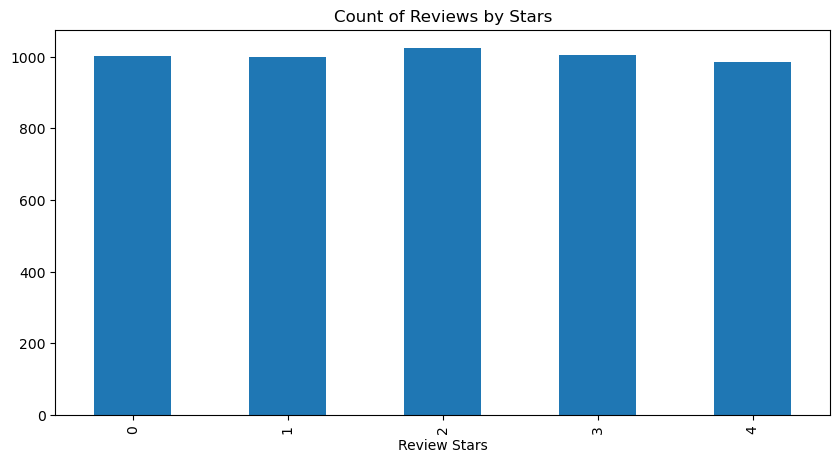

In [4]:
ax = df['label'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show()

In [5]:
example = df['processed_review'][215]
rating = df['label'][215]
example, rating

('big company lapsed process removed many employees instead helping crucial time worst ever company',
 1)

In [6]:
import torch
from transformers import AutoTokenizer

# Create The Dataset Class.
class TheDataset(torch.utils.data.Dataset):

    def __init__(self, reviews, sentiments, tokenizer):
        self.reviews    = reviews
        self.sentiments = sentiments
        self.tokenizer  = tokenizer
        self.max_len    = tokenizer.model_max_length
        # self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  
    def __len__(self):
        return len(self.reviews)
  
    def __getitem__(self, index):
        review = str(self.reviews[index])
        sentiments = self.sentiments[index]

        encoded_review = self.tokenizer.encode_plus(
            review,
            add_special_tokens    = True,
            max_length            = self.max_len,
            return_token_type_ids = False,
            return_attention_mask = True,
            return_tensors        = "pt",
            padding               = "max_length",
            truncation            = True
        )

        return {
            'input_ids': encoded_review['input_ids'][0],
            'attention_mask': encoded_review['attention_mask'][0],
            'labels': torch.tensor(sentiments, dtype=torch.long)
        }

In [7]:
from sklearn.model_selection import train_test_split
X = df['processed_review'].tolist()
Y = df['label'].tolist()

combined_data = list(zip(X, Y))
np.random.shuffle(combined_data)
X_shuffled, Y_shuffled = zip(*combined_data)

X_train, X_temp, y_train, y_temp = train_test_split(X_shuffled, Y_shuffled, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [8]:
def class_proportions(y):
    unique, counts = np.unique(y, return_counts=True)
    return dict(zip(unique, counts / len(y)))

print("Training set class proportions:", class_proportions(y_train))
print("Validation set class proportions:", class_proportions(y_val))
print("Testing set class proportions:", class_proportions(y_test))

Training set class proportions: {0: 0.2025442753803941, 1: 0.2030431529059616, 2: 0.20503866300823148, 3: 0.19680718383636817, 4: 0.19256672486904464}
Validation set class proportions: {0: 0.19760479041916168, 1: 0.17564870259481039, 2: 0.2215568862275449, 3: 0.1996007984031936, 4: 0.2055888223552894}
Testing set class proportions: {0: 0.17928286852589642, 1: 0.19123505976095617, 2: 0.18127490039840638, 3: 0.2290836653386454, 4: 0.21912350597609562}


In [9]:
tokenizer = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")
# Create Dataset objects for train/validation sets.
train_set_dataset = TheDataset(
    reviews    = X_train,
    sentiments = y_train,
    tokenizer  = tokenizer,
)

In [10]:
valid_set_dataset = TheDataset(
    reviews    = X_val,
    sentiments = y_val,
    tokenizer  = tokenizer,
)

In [11]:
train_set_dataloader = torch.utils.data.DataLoader(
    train_set_dataset,
    batch_size  = 16,
    num_workers = 4
)

valid_set_dataloader = torch.utils.data.DataLoader(
    valid_set_dataset,
    batch_size  = 16,
    num_workers = 4
)

In [12]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments

model = AutoModelForSequenceClassification.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")

In [13]:
for name, param in model.bert.named_parameters():
    if ( not name.startswith('pooler') ) and "layer.23" not in name :
        param.requires_grad = False

In [14]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,


        'f1': f1,
        'precision': precision,
        'recall': recall
    }

training_args = TrainingArguments(
    output_dir                  = "./sentiment-analysis",
    num_train_epochs            = 15,
    per_device_train_batch_size = 32,
    per_device_eval_batch_size  = 32,
    warmup_steps                = 500,
    weight_decay                = 0.01,
    save_strategy               = "epoch",
    evaluation_strategy         = "steps"
)

trainer = Trainer(
    model           = model,
    args            = training_args,
    train_dataset   = train_set_dataset,
    
    eval_dataset    = valid_set_dataset,
    compute_metrics = compute_metrics
    
)

trainer.train()

  0%|          | 0/1890 [00:00<?, ?it/s]

{'loss': 1.2947, 'grad_norm': 1.0142825841903687, 'learning_rate': 5e-05, 'epoch': 3.97}


  0%|          | 0/16 [00:00<?, ?it/s]

{'eval_loss': 1.1736128330230713, 'eval_accuracy': 0.5469061876247505, 'eval_f1': 0.5451756905109241, 'eval_precision': 0.5450387257318848, 'eval_recall': 0.5469061876247505, 'eval_runtime': 47.6991, 'eval_samples_per_second': 10.503, 'eval_steps_per_second': 0.335, 'epoch': 3.97}
{'loss': 1.1274, 'grad_norm': 1.2785018682479858, 'learning_rate': 3.201438848920863e-05, 'epoch': 7.94}


  0%|          | 0/16 [00:00<?, ?it/s]

{'eval_loss': 1.0918807983398438, 'eval_accuracy': 0.5828343313373253, 'eval_f1': 0.5757189504435801, 'eval_precision': 0.581470519487302, 'eval_recall': 0.5828343313373253, 'eval_runtime': 46.7183, 'eval_samples_per_second': 10.724, 'eval_steps_per_second': 0.342, 'epoch': 7.94}
{'loss': 1.084, 'grad_norm': 1.365444302558899, 'learning_rate': 1.4028776978417266e-05, 'epoch': 11.9}


  0%|          | 0/16 [00:00<?, ?it/s]

{'eval_loss': 1.0801273584365845, 'eval_accuracy': 0.5708582834331337, 'eval_f1': 0.5672302722220218, 'eval_precision': 0.5702750020293152, 'eval_recall': 0.5708582834331337, 'eval_runtime': 43.8861, 'eval_samples_per_second': 11.416, 'eval_steps_per_second': 0.365, 'epoch': 11.9}
{'train_runtime': 5603.032, 'train_samples_per_second': 10.733, 'train_steps_per_second': 0.337, 'train_loss': 1.1492468778418485, 'epoch': 15.0}


TrainOutput(global_step=1890, training_loss=1.1492468778418485, metrics={'train_runtime': 5603.032, 'train_samples_per_second': 10.733, 'train_steps_per_second': 0.337, 'train_loss': 1.1492468778418485, 'epoch': 15.0})

In [15]:
trainer.evaluate(eval_dataset=valid_set_dataset)

  0%|          | 0/16 [00:00<?, ?it/s]

{'eval_loss': 1.07370924949646,
 'eval_accuracy': 0.564870259481038,
 'eval_f1': 0.5608505820036007,
 'eval_precision': 0.561978212531929,
 'eval_recall': 0.564870259481038,
 'eval_runtime': 41.9483,
 'eval_samples_per_second': 11.943,
 'eval_steps_per_second': 0.381,
 'epoch': 15.0}

: 